In [11]:
import torch
from torch import nn
import torchvision
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from dataset import FkDataset
import torchvision.transforms as t
from torch.utils.data import DataLoader


def log(*m):
    if DEBUG:
        print(*m)


class Elu(nn.Module):
    def forward(self, x):
        return torch.nn.functional.elu(x)

class Downsample:
    def __init__(self, size, mode="bicubic"):
        self.size = size
        self.mode = mode
    
    def __call__(self, x):
        return torch.nn.functional.interpolate(x, self.size)


class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pooling=2):
        super().__init__()
        self.features = nn.ModuleList(
            [
                nn.Conv3d(in_channels, out_channels, kernel_size=(3, kernel_size, kernel_size), padding=padding),
                Elu(),
                nn.Conv3d(out_channels, out_channels, kernel_size=(3, kernel_size, kernel_size), padding=padding),
                Elu()
            ])
        self.downsample = nn.AvgPool3d((1, pooling, pooling)) if pooling else nn.Identity()

    def forward(self, x):
        log("going down")
        for i in range(len(self.features)):
            x = self.features[i](x)
            log("conv", i, x.shape)
        x = self.downsample(x)
        log("pool", i, x.shape)
        return x


class ConvTransposeBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pooling=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=(1, pooling, pooling))
        self.features = ConvBlock3D(in_channels, out_channels, kernel_size=3, padding=padding, pooling=0)

    def forward(self, x, skip_connection):
        log("going up")
        log("cat", x.shape)
        x = self.features(x + skip_connection)
        log("conv", x.shape)
        x = self.upsample(x)
        log("upsample", x.shape, skip_connection.shape)        
        return x


class Unet3D(LightningModule):
    def __init__(self, channels, first_channel, last_channel, scale_factor=4):
        super().__init__()

        down_channels = [first_channel] + channels if first_channel is not None else channels
        self.downscale = nn.ModuleList()
        for i in range(len(down_channels) - 1):
            self.downscale.append(ConvBlock3D(down_channels[i], down_channels[i + 1], pooling=scale_factor))
        
        up_channels = [last_channel] + channels if last_channel is not None else channels
        self.upscale = nn.ModuleList()
        for i in range(len(up_channels) - 1):
            self.upscale.append(ConvTransposeBlock3D(up_channels[-i - 1], up_channels[-i - 2], pooling=scale_factor))
        return
    
    def encode(self, x):
        skip_connections = []
        for i in range(len((self.downscale))):
            x = self.downscale[i](x)
            skip_connections.append(x)
        return x, skip_connections
    
    def propagate(self, x):
        # implement normalizing flow here
        return x
    
    def decode(self, x, skip_connections):
        for i in range(len((self.upscale))):
            x = self.upscale[i](x, skip_connections[-i - 1])
        return x
    
    def forward(self, x):
        x, skip_connections = self.encode(x)
        log("skip connections", [x.shape for x in skip_connections])
        x = self.propagate(x)
        x = self.decode(x, skip_connections)
        return x
    
    def parameters_count(self):
        return sum(p.numel() for p in self.parameters())
    
    def get_loss(self, y_hat, y):
        return nn.functional.mse_loss(y_hat, y, reduction="sum")
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    def train_dataloader(self):
        fkset = FkDataset(ROOT, FRAMES_IN, FRAMES_OUT, 1, transforms=t.Compose([Downsample((INPUT_SIZE, INPUT_SIZE))]), squeeze=True)
        loader = DataLoader(fkset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0 if DEBUG else 12)
        return loader
    
    def training_step(self, batch, batch_idx):
        print(batch.shape)
        for t in batch:
            if (t is None):
                print(batch_idx, i)
        x = batch[:, :FRAMES_IN]
        y = batch[:, FRAMES_IN:]
        log(x.shape)
        log(y.shape)
        
        y_hat = self(x)
        loss = self.get_loss(y_hat, y)

        tensorboard_logs = {'train_loss': loss}

        return {"loss": loss, "log": tensorboard_logs}
    
#     def training_epoch_end(self, outputs):
#         grid = torchvision.utils.make_grid(outputs)
#         self.logger.experiment.add_image("Prediction", grid, 0)
#         self.logger.experiment.add_image("Truth", grid, 0)
#         return
        

if __name__ == "__main__":
    DEBUG = False
    ROOT = "/media/SSD1/epignatelli/train_dev_set"
    BATCH_SIZE = 4
    FRAMES_IN = 7
    FRAMES_OUT = 9
    INPUT_SIZE = 256
    SCALE_FACTOR = 4
    CHANNELS = [8, 16, 32, 64]

    
    model = Unet3D(CHANNELS, FRAMES_IN, FRAMES_OUT, scale_factor=SCALE_FACTOR)
    log(model)
    log("parameters: {}".format(model.parameters_count()))
    trainer = Trainer(fast_dev_run=DEBUG, gpus=1)
    trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | downscale | ModuleList | 221 K 
1 | upscale   | ModuleList | 113 K 


torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])
torch.Size([4, 16, 3, 256, 256])


AttributeError: Caught AttributeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/ep119/.conda/envs/fk/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ep119/.conda/envs/fk/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/ep119/.conda/envs/fk/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 52, in default_collate
    numel = sum([x.numel() for x in batch])
  File "/home/ep119/.conda/envs/fk/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 52, in <listcomp>
    numel = sum([x.numel() for x in batch])
AttributeError: 'NoneType' object has no attribute 'numel'


In [3]:
fkset = FkDataset(ROOT, FRAMES_IN, FRAMES_OUT, 1, transforms=t.Compose([Downsample((INPUT_SIZE, INPUT_SIZE))]), squeeze=True)
loader = DataLoader(fkset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0 if DEBUG else 12)

In [10]:
fkset[16*4].shape

torch.Size([16, 3, 256, 256])

In [ ]:
for batch in loader:
    print(batch.shape)
    break

In [ ]:
fkset[5].shape

In [11]:
import torch
a = torch.randn(4, 16, 3, 256, 256)
(a[:, :, :, :, 2:] - a[:, :, :, :, :-2]).shape

torch.Size([4, 16, 3, 256, 254])

TypeError: Invalid shape (3, 256, 256) for image data

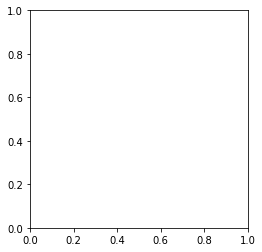

In [17]:
import matplotlib.pyplot as plt
plt.imshow(a.numpy()[0, 0])
# plt.imshow((a[:, :, :, :, 2:] - a[:, :, :, :, :-2]).numpy()[0, 0])

In [7]:
a[:, :, :, :, 2:].shape

torch.Size([4, 16, 3, 256, 254])

In [9]:
a[:, :, :, :, :-2].shape

torch.Size([4, 16, 3, 256, 254])

In [1]:
torch.nn.functional.pad()

NameError: name 'torch' is not defined

In [2]:
slice(1, 10, 2)

slice(1, 10, 2)

In [9]:
list(range(100)[(slice(1, 10, 2))])

[1, 3, 5, 7, 9]

In [27]:
import torch
from torch import nn
import torchvision
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from dataset import FkDataset, Simulation
import torchvision.transforms as t
from torch.utils.data import DataLoader
from torchvision.utils import make_grid as mg
import fk

DEBUG = False
ROOT = "/media/SSD1/epignatelli/train_dev_set"
FILENAME = "/media/SSD1/epignatelli/train_dev_set/spiral_params5.hdf5"
BATCH_SIZE = 64
FRAMES_IN = 5
FRAMES_OUT = 10
STEP = 10
INPUT_SIZE = 256
SCALE_FACTOR = 4
CHANNELS = [16, 32, 64, 128]
    
    
fkset = Simulation(FILENAME, FRAMES_IN, FRAMES_OUT, STEP)
loader = DataLoader(fkset, batch_size=BATCH_SIZE, shuffle=True)

In [28]:
fkset[10].shape

(15, 3, 256, 256)

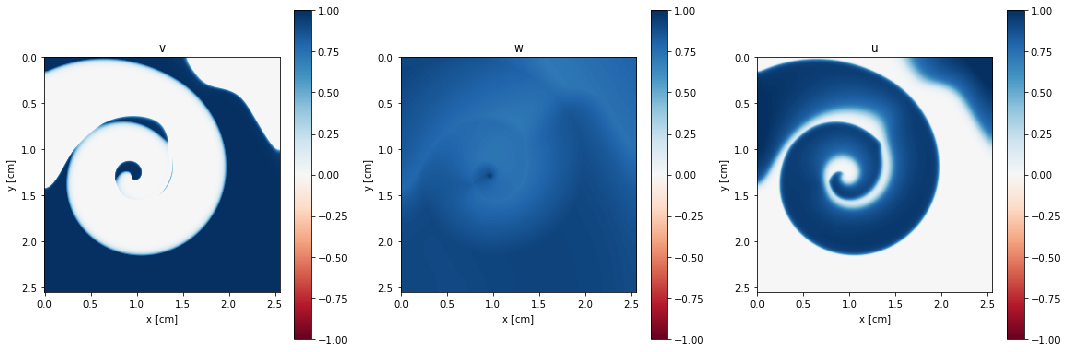

(<Figure size 1080x360 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1791519d0>,
       dtype=object))

In [29]:
fk.plot.show(fkset[600][1])

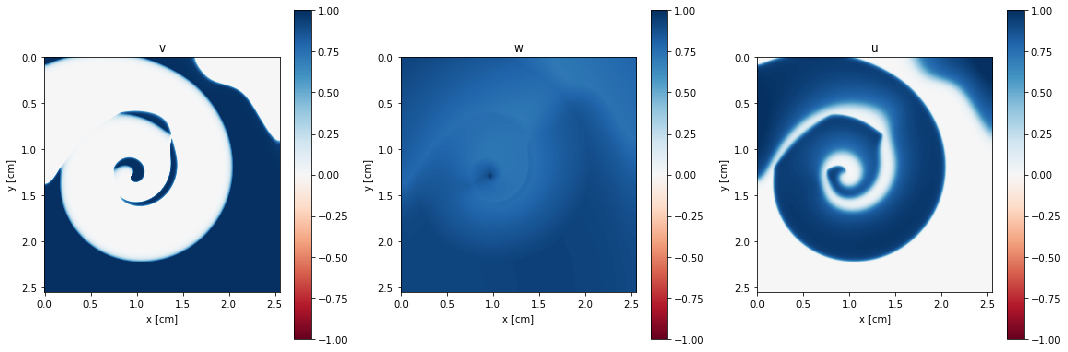

(<Figure size 1080x360 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd178ecec10>,
       dtype=object))

In [30]:
fk.plot.show(fkset[600][2])

In [33]:
torch.randn(5, 10, 34, 21).size(0)

5